<a href="https://colab.research.google.com/github/akash99955/AML/blob/main/AML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

#First of all, please upload the dataset in colab then after run


# ============================================================
# SETUP: Install + Imports
# ============================================================

# ---------- 1) Install dependencies ----------
!pip -q install transformers datasets torch scikit-learn matplotlib seaborn wordcloud pandas numpy nltk kagglehub

# ---------- 2) Core Imports ----------
import os, re, time, warnings
import numpy as np
import pandas as pd
import torch

warnings.filterwarnings("ignore")

# ---------- 3) Transformers (BERT) ----------
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments
)

# ---------- 4) Visualization ----------
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from IPython.display import display, HTML
from collections import Counter

# ---------- 5) NLTK (Text Preprocessing) ----------
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.probability import FreqDist

# ---------- 6) Scikit-learn (ML + Metrics) ----------
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve,
    f1_score, precision_score, recall_score
)

print(" All libraries imported successfully!")

# ============================================================
# NLTK Downloads
# ============================================================
print("\n Downloading NLTK resources...")
nltk.download("stopwords", quiet=True)
nltk.download("punkt", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("averaged_perceptron_tagger", quiet=True)
nltk.download("punkt_tab", quiet=True)
print(" NLTK resources downloaded!")



 All libraries imported successfully!

 NLTK resources downloaded!


In [ ]:
# ============================================================
# PART 2: LOAD DATASET + BASIC OVERVIEW (FULL WORKING, CLEAN FORMAT)
# ============================================================

# ---------- 1) Load dataset ----------
df = pd.read_csv("Tweets.csv")

print(f" Dataset loaded → {df.shape[0]:,} tweets")
print(f" Columns ({len(df.columns)}): {df.columns.tolist()}")


# ---------- 2) Map sentiment text to numeric labels ----------
sentiment_map = {
    "negative": 0,
    "neutral":  1,
    "positive": 2
}

df["sentiment_label"] = df["airline_sentiment"].map(sentiment_map)


# ---------- 3) Count each class safely ----------
sentiment_counts = df["sentiment_label"].value_counts(dropna=False)

negative_count = int(sentiment_counts.get(0, 0))
neutral_count  = int(sentiment_counts.get(1, 0))
positive_count = int(sentiment_counts.get(2, 0))

print("\n Sentiment distribution (numeric labels):")
print(f"   Negative (0): {negative_count:,}")
print(f"   Neutral  (1): {neutral_count:,}")
print(f"   Positive (2): {positive_count:,}")


# ---------- 4) Unique values per column (summary table) ----------
unique_summary = (
    pd.DataFrame({
        "Column Name": df.columns,
        "Unique Values": [df[col].nunique(dropna=True) for col in df.columns],
        "Missing Values": [df[col].isna().sum() for col in df.columns],
        "Data Type": [df[col].dtype for col in df.columns]
    })
    .sort_values("Unique Values", ascending=False)
    .reset_index(drop=True)
)

print("\n Unique Values Summary (with missing + dtype):")
display(unique_summary)


 Dataset loaded → 14,640 tweets
 Columns (15): ['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'text', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone']

 Sentiment distribution (numeric labels):
   Negative (0): 9,178
   Neutral  (1): 3,099
   Positive (2): 2,363

 Unique Values Summary (with missing + dtype):


,Column Name,Unique Values,Missing Values,Data Type
0,tweet_id,14485,0,int64
1,text,14427,0,object
2,tweet_created,14247,0,object
3,name,7701,0,object
4,tweet_location,3081,4733,object
5,negativereason_confidence,1410,4118,float64
6,airline_sentiment_confidence,1023,0,float64
7,tweet_coord,832,13621,object
8,user_timezone,85,4820,object
9,retweet_count,18,0,int64


In [ ]:
# ============================================================
# PART 3: TEXT PREPROCESSING PIPELINE
# ============================================================


# ============================================================
# TEXT PREPROCESSOR CLASS
# ============================================================

class TextPreprocessor:
    """
    Handles text cleaning and normalization for sentiment analysis.
    Steps:
    1. Text cleaning
    2. Tokenization
    3. Stopword removal
    4. Lemmatization
    """

    def __init__(self):
        self.stopwords = set(stopwords.words("english"))
        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = PorterStemmer()  # (kept for extensibility)

    def _basic_cleaning(self, text):
        """Lowercase and remove noise such as URLs and symbols"""
        if not isinstance(text, str):
            return ""

        text = text.lower()
        text = re.sub(r"http\S+|www\S+", "", text)   # remove URLs
        text = re.sub(r"@\w+", "", text)             # remove mentions
        text = re.sub(r"#\w+", "", text)             # remove hashtags
        text = re.sub(r"[^a-z\s]", "", text)         # keep letters only
        text = re.sub(r"\s+", " ", text).strip()     # normalize spaces

        return text

    def _tokenize(self, text):
        """Split sentence into tokens"""
        return word_tokenize(text)

    def _remove_stopwords(self, tokens):
        """Filter out common English stopwords"""
        return [t for t in tokens if t not in self.stopwords]

    def _lemmatize(self, tokens):
        """Convert words to base form"""
        return [self.lemmatizer.lemmatize(t) for t in tokens]

    def transform(self, text):
        """Complete preprocessing pipeline"""
        cleaned_text = self._basic_cleaning(text)
        tokens = self._tokenize(cleaned_text)
        tokens = self._remove_stopwords(tokens)
        tokens = self._lemmatize(tokens)

        return " ".join(tokens)


# ============================================================
# INITIALIZE PREPROCESSOR
# ============================================================

preprocessor = TextPreprocessor()


# ============================================================
# PREPROCESSING DEMO (SAMPLE OUTPUT)
# ============================================================

print("\n TEXT PREPROCESSING SAMPLE")
print("-" * 55)

sample_tweets = df["text"].head(3).values

for idx, tweet in enumerate(sample_tweets, start=1):
    print(f"\nExample {idx}")
    print(f"Original  : {tweet[:120]}...")
    cleaned = preprocessor.transform(tweet)
    print(f"Processed : {cleaned[:120]}...")


# ============================================================
# APPLY PREPROCESSING TO FULL DATASET
# ============================================================

print("\n Applying preprocessing to entire dataset...")

df["cleaned_text"] = df["text"].apply(preprocessor.transform)

print(" Preprocessing completed successfully!")
print(" New column added: 'cleaned_text'")



 TEXT PREPROCESSING SAMPLE
-------------------------------------------------------

Example 1
Original  : @VirginAmerica What @dhepburn said....
Processed : said...

Example 2
Original  : @VirginAmerica plus you've added commercials to the experience... tacky....
Processed : plus youve added commercial experience tacky...

Example 3
Original  : @VirginAmerica I didn't today... Must mean I need to take another trip!...
Processed : didnt today must mean need take another trip...

 Applying preprocessing to entire dataset...
 Preprocessing completed successfully!
 New column added: 'cleaned_text'


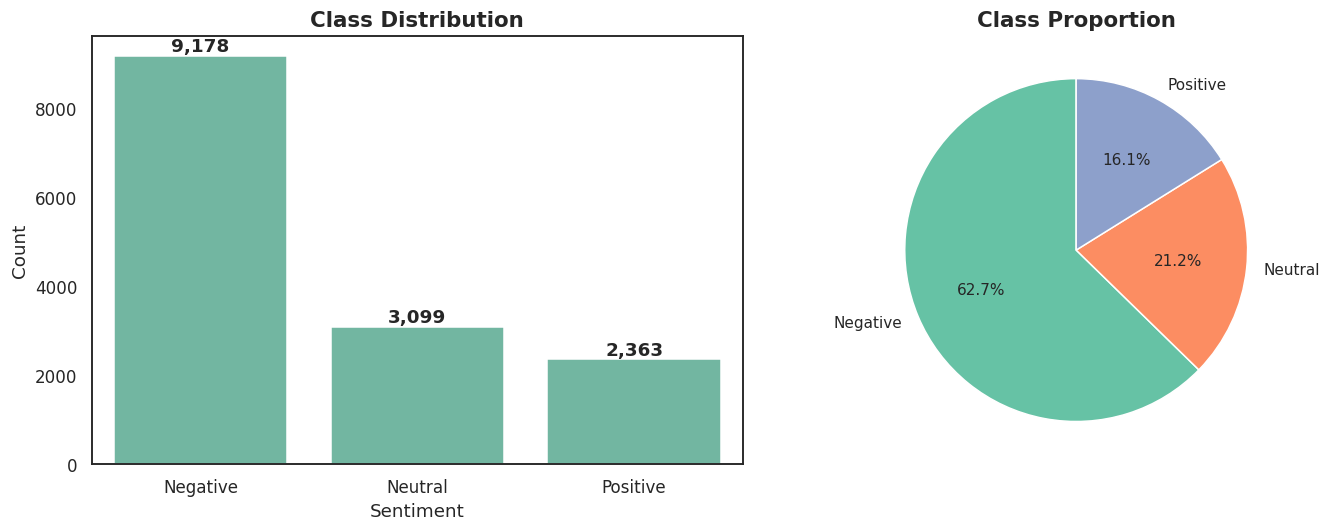

 Generating word clouds for 3 classes...


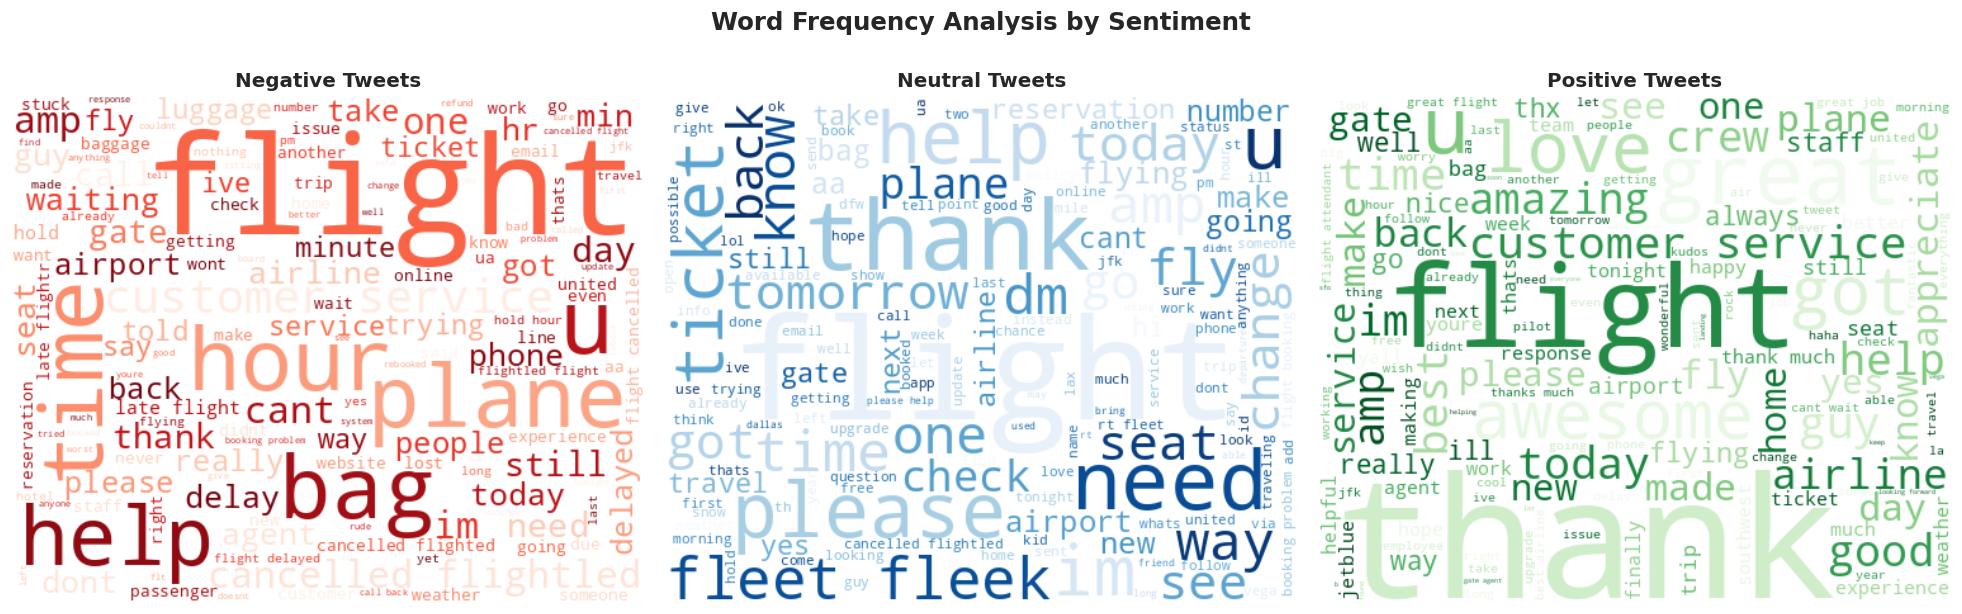

 Word clouds generated successfully!


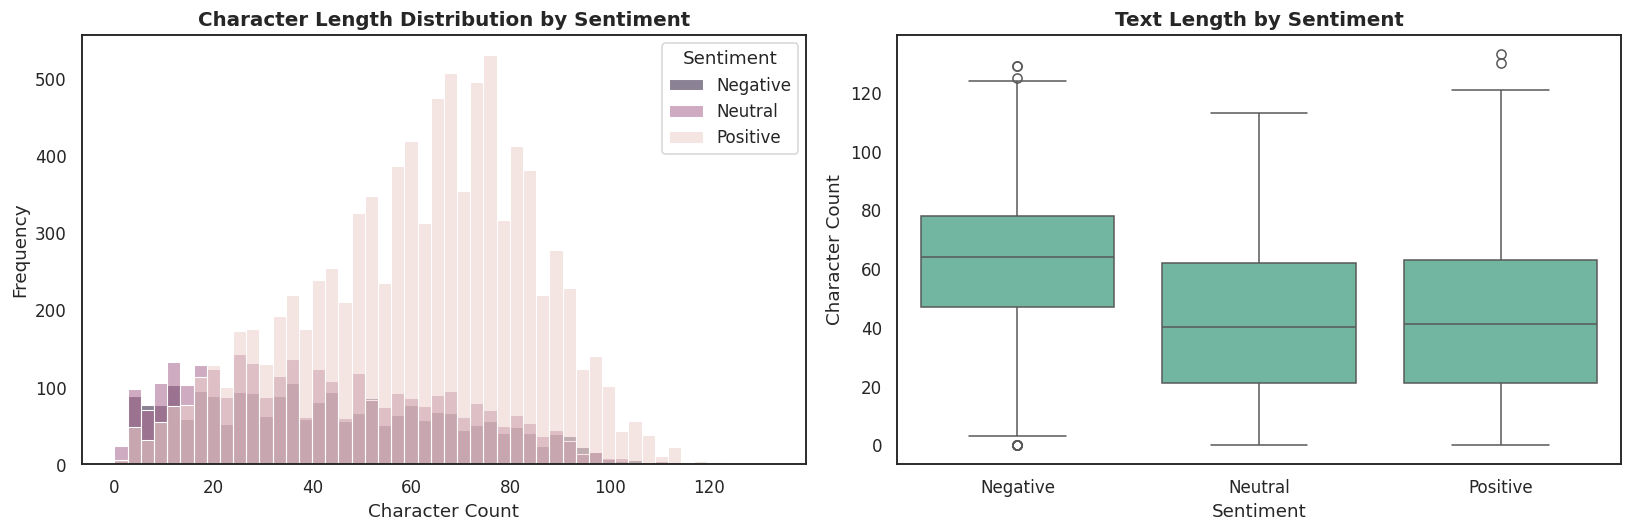

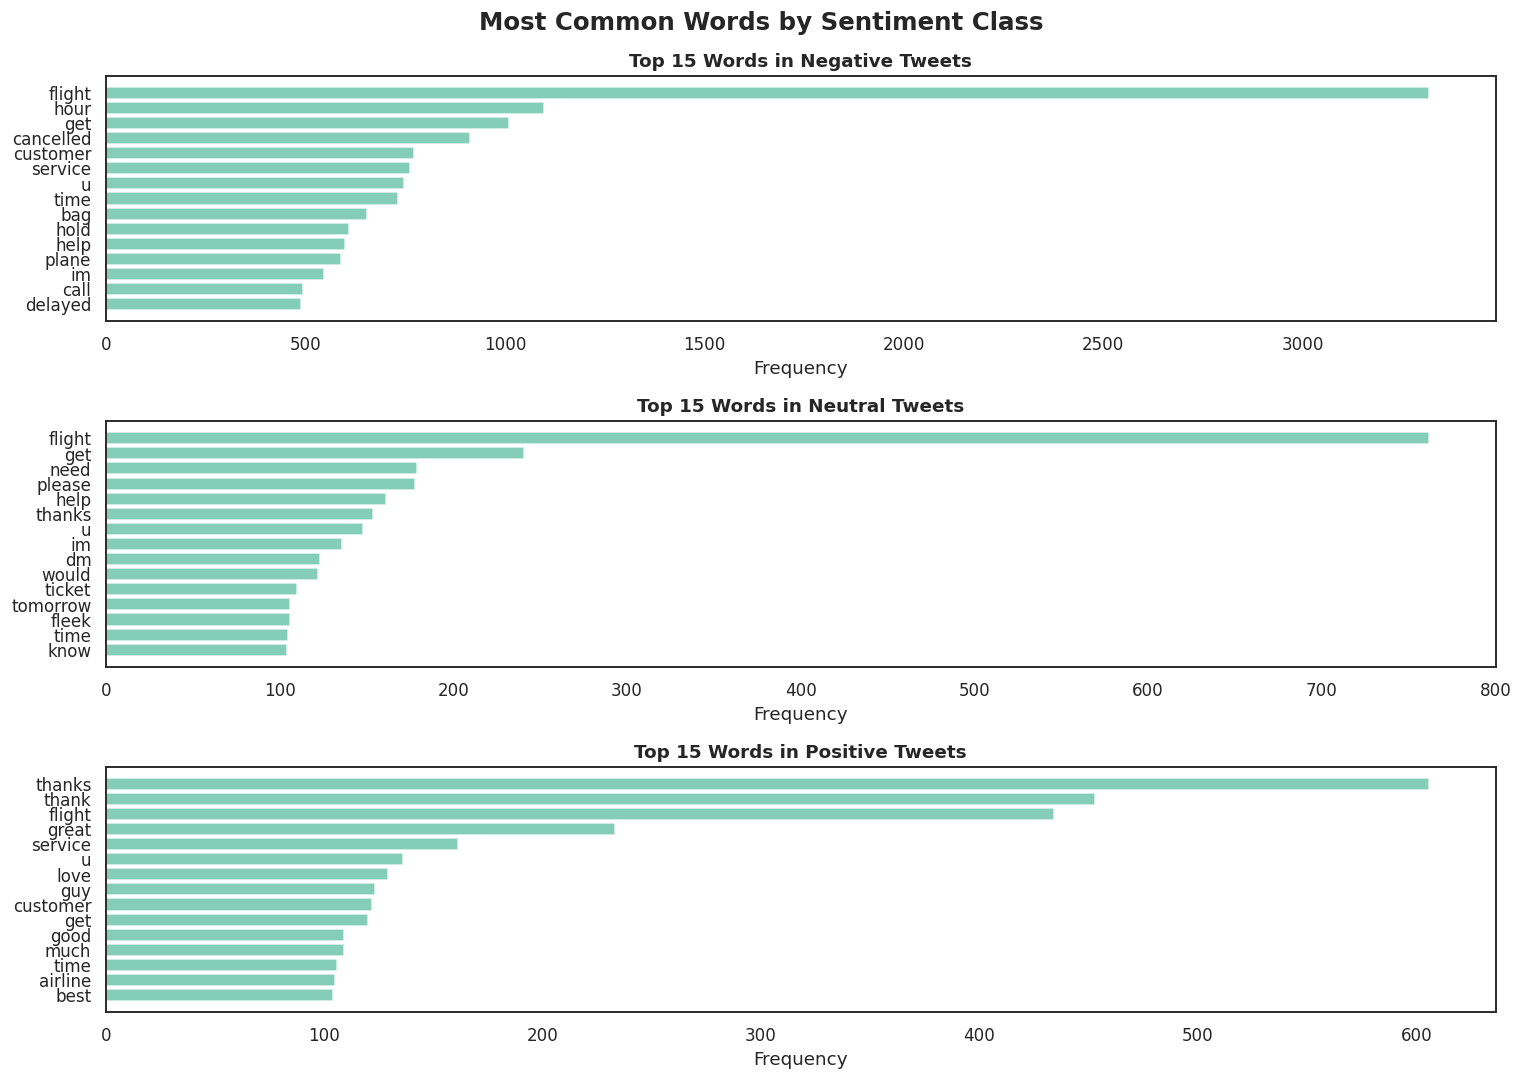

 All visualizations completed successfully!


In [ ]:
# ============================================================
# PART 4: VISUALIZATIONS (3-CLASS SENTIMENT)
# Same outputs, cleaner + different formatting/style
# ============================================================


# -----------------------------
# Global plot styling (different from yours)
# -----------------------------
sns.set_theme(style="white", context="notebook")
sns.set_palette("Set2")
plt.rcParams["figure.dpi"] = 110


# ============================================================
# VISUAL 1: CLASS DISTRIBUTION (BAR + PIE)
# ============================================================

label_names = {0: "Negative", 1: "Neutral", 2: "Positive"}

counts = df["sentiment_label"].value_counts().sort_index()
counts.index = counts.index.map(label_names)

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Bar chart
sns.barplot(x=counts.index, y=counts.values, ax=axes[0])
axes[0].set_title("Class Distribution", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Sentiment")
axes[0].set_ylabel("Count")

# Add labels above bars
for i, v in enumerate(counts.values):
    axes[0].text(i, v + max(counts.values) * 0.01, f"{v:,}", ha="center", fontweight="bold")

# Pie chart
axes[1].pie(
    counts.values,
    labels=counts.index,
    autopct="%1.1f%%",
    startangle=90,
    textprops={"fontsize": 10}
)
axes[1].set_title("Class Proportion", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()


# ============================================================
# VISUAL 2: WORDCLOUDS FOR EACH CLASS
# ============================================================

print(" Generating word clouds for 3 classes...")

def safe_sample(df_part, n, seed=42):
    """Sample safely even when class size is smaller than n."""
    n = min(n, len(df_part))
    return df_part.sample(n=n, random_state=seed) if n > 0 else df_part

# Choose balanced sample size for speed
sample_size = min(15000, len(df) // 3)

neg_df = safe_sample(df[df["sentiment_label"] == 0], sample_size)
neu_df = safe_sample(df[df["sentiment_label"] == 1], sample_size)
pos_df = safe_sample(df[df["sentiment_label"] == 2], sample_size)

neg_text = " ".join(neg_df["cleaned_text"].astype(str))
neu_text = " ".join(neu_df["cleaned_text"].astype(str))
pos_text = " ".join(pos_df["cleaned_text"].astype(str))

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

wc_specs = [
    ("Negative Tweets", neg_text, "Reds"),
    ("Neutral Tweets",  neu_text, "Blues"),
    ("Positive Tweets", pos_text, "Greens"),
]

for ax, (title, txt, cmap) in zip(axes, wc_specs):
    wc = WordCloud(
        width=500,
        height=400,
        background_color="white",
        max_words=150,
        colormap=cmap
    ).generate(txt)
    ax.imshow(wc, interpolation="bilinear")
    ax.set_title(title, fontsize=13, fontweight="bold")
    ax.axis("off")

plt.suptitle("Word Frequency Analysis by Sentiment", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

print(" Word clouds generated successfully!")


# ============================================================
# VISUAL 3: TEXT LENGTH DISTRIBUTION (HIST + BOXPLOT)
# ============================================================

# Create length features
df["text_length"] = df["cleaned_text"].astype(str).apply(len)
df["word_count"] = df["cleaned_text"].astype(str).apply(lambda x: len(x.split()))

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram by class
sns.histplot(
    data=df,
    x="text_length",
    hue="sentiment_label",
    bins=50,
    alpha=0.55,
    ax=axes[0]
)
axes[0].set_title("Character Length Distribution by Sentiment", fontsize=13, fontweight="bold")
axes[0].set_xlabel("Character Count")
axes[0].set_ylabel("Frequency")
axes[0].legend(title="Sentiment", labels=["Negative", "Neutral", "Positive"])

# Boxplot
sns.boxplot(
    data=df,
    x="sentiment_label",
    y="text_length",
    ax=axes[1]
)
axes[1].set_title("Text Length by Sentiment", fontsize=13, fontweight="bold")
axes[1].set_xlabel("Sentiment")
axes[1].set_ylabel("Character Count")
axes[1].set_xticklabels(["Negative", "Neutral", "Positive"])

plt.tight_layout()
plt.show()


# ============================================================
# VISUAL 4: TOP WORDS PER CLASS (HORIZONTAL BAR)
# ============================================================

def top_words(series, k=15):
    words = []
    for t in series.astype(str):
        words.extend(t.split())
    return Counter(words).most_common(k)

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

for label, ax in zip([0, 1, 2], axes):
    subset = df[df["sentiment_label"] == label]
    pairs = top_words(subset["cleaned_text"], k=15)

    words = [w for w, c in pairs]
    freqs = [c for w, c in pairs]

    ax.barh(words, freqs, alpha=0.8)
    ax.invert_yaxis()
    ax.set_title(f"Top 15 Words in {label_names[label]} Tweets", fontsize=12, fontweight="bold")
    ax.set_xlabel("Frequency")

plt.suptitle("Most Common Words by Sentiment Class", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()


# ============================================================
# VISUAL 5: SENTIMENT OVER TIME (ONLY IF DATE EXISTS)
# ============================================================

if "date" in df.columns:
    try:
        temp = df.copy()
        temp["date"] = pd.to_datetime(temp["date"], errors="coerce")
        temp = temp.dropna(subset=["date"])
        temp["month"] = temp["date"].dt.to_period("M").astype(str)

        trend = temp.groupby(["month", "sentiment_label"]).size().unstack(fill_value=0)
        trend = trend.rename(columns=label_names)

        plt.figure(figsize=(12, 6))
        for col in trend.columns:
            plt.plot(trend.index, trend[col], marker="o", linewidth=2, label=col)

        plt.title("Sentiment Trends Over Time", fontsize=14, fontweight="bold")
        plt.xlabel("Month")
        plt.ylabel("Number of Tweets")
        plt.xticks(rotation=45)
        plt.grid(alpha=0.25)
        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(" Could not create time series visualization:", e)

print(" All visualizations completed successfully!")




In [ ]:
# ============================================================
# PART 5: BALANCE DATASET + TRAIN/TEST SPLIT (CLEAN FORMAT)
# ============================================================


print("\n Preparing a balanced training dataset...")

# ---------- 1) Check class counts ----------
class_counts = df["sentiment_label"].value_counts().sort_index()
min_per_class = int(class_counts.min())

print("\nClass counts (before balancing):")
for label, cnt in class_counts.items():
    print(f"  {label} ({['Negative','Neutral','Positive'][label]}): {cnt:,}")

print(f"\nBalancing to {min_per_class:,} samples per class...")


# ---------- 2) Balance each class safely ----------
balanced_data = (
    df.groupby("sentiment_label", group_keys=False)
      .apply(lambda x: x.sample(n=min_per_class, random_state=42))
      .sample(frac=1, random_state=42)   # shuffle
      .reset_index(drop=True)
)

print(f"\n Balanced dataset created: {len(balanced_data):,} tweets")

balanced_counts = balanced_data["sentiment_label"].value_counts().sort_index()
print("Balanced class counts:")
for label, cnt in balanced_counts.items():
    print(f"  {label} ({['Negative','Neutral','Positive'][label]}): {cnt:,}")


# ---------- 3) Train-test split (stratified) ----------
train_df, test_df = train_test_split(
    balanced_data,
    test_size=0.20,
    random_state=42,
    stratify=balanced_data["sentiment_label"]
)

print("\n Train-Test Split Summary")
print(f"  Train samples: {len(train_df):,}")
print(f"  Test samples : {len(test_df):,}")

train_counts = train_df["sentiment_label"].value_counts().sort_index()
test_counts  = test_df["sentiment_label"].value_counts().sort_index()

print("\nTrain distribution:")
for label, cnt in train_counts.items():
    print(f"  {label} ({['Negative','Neutral','Positive'][label]}): {cnt:,}")

print("\nTest distribution:")
for label, cnt in test_counts.items():
    print(f"  {label} ({['Negative','Neutral','Positive'][label]}): {cnt:,}")



 Preparing a balanced training dataset...

Class counts (before balancing):
  0 (Negative): 9,178
  1 (Neutral): 3,099
  2 (Positive): 2,363

Balancing to 2,363 samples per class...

 Balanced dataset created: 7,089 tweets
Balanced class counts:
  0 (Negative): 2,363
  1 (Neutral): 2,363
  2 (Positive): 2,363

 Train-Test Split Summary
  Train samples: 5,671
  Test samples : 1,418

Train distribution:
  0 (Negative): 1,891
  1 (Neutral): 1,890
  2 (Positive): 1,890

Test distribution:
  0 (Negative): 472
  1 (Neutral): 473
  2 (Positive): 473


In [ ]:
# ===================================
# MODEL 1: RANDOM FOREST (TF-IDF + RF)
# ===================================


print("\n MODEL 1: RANDOM FOREST")
print("=" * 55)

# ------------------------------------------------------------
# STEP 1: TF-IDF (Tree-friendly settings)
# ------------------------------------------------------------
print("\n STEP 1: TF-IDF FEATURE EXTRACTION")
print("-" * 45)

tfidf_rf = TfidfVectorizer(
    max_features=8000,         # larger vocab for trees
    stop_words="english",
    ngram_range=(1, 2),        # unigram + bigram
    min_df=5,                  # remove rare tokens
    max_df=0.80                # remove too-common tokens
)

X_train_rf = tfidf_rf.fit_transform(train_df["cleaned_text"].astype(str))
X_test_rf  = tfidf_rf.transform(test_df["cleaned_text"].astype(str))

print(" TF-IDF done!")
print(f"   Train shape: {X_train_rf.shape}")
print(f"   Test shape : {X_test_rf.shape}")
print(f"   Vocab size : {len(tfidf_rf.vocabulary_):,}")


# ------------------------------------------------------------
# STEP 2: Random Forest Training
# ------------------------------------------------------------
print("\n STEP 2: TRAIN RANDOM FOREST")
print("-" * 45)

'''
#Attempt 1
rf_model = RandomForestClassifier(
    n_estimators=50,           # Number of trees
    max_depth=20,               # Maximum depth of each tree
    min_samples_split=5,        # Minimum samples to split node
    min_samples_leaf=2,         # Minimum samples in leaf node
    max_features='sqrt',        # Features to consider for split
    random_state=42,            # Reproducibility
    class_weight='balanced',    # Handle class imbalance
    n_jobs=-1                   # Use all processors
)
#Attempt 2
rf_model = RandomForestClassifier(
    n_estimators=100,           # Number of trees
    max_depth=20,               # Maximum depth of each tree
    min_samples_split=5,        # Minimum samples to split node
    min_samples_leaf=2,         # Minimum samples in leaf node
    max_features='sqrt',        # Features to consider for split
    random_state=42,            # Reproducibility
    class_weight='balanced',    # Handle class imbalance
    n_jobs=-1                   # Use all processors
)
'''
rf = RandomForestClassifier(
    n_estimators=1000,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features="sqrt",
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

t0 = time.time()
rf.fit(X_train_rf, train_df["sentiment_label"])
train_time = time.time() - t0

print(f" Random Forest training completed in {train_time:.2f} sec")


# ------------------------------------------------------------
# STEP 3: Predictions
# ------------------------------------------------------------
print("\n STEP 3: PREDICTIONS")
print("-" * 45)

y_true = test_df["sentiment_label"].values
y_pred_rf = rf.predict(X_test_rf)
y_prob_rf = rf.predict_proba(X_test_rf)

print(" Predictions generated!")
print(f"   Sample preds : {y_pred_rf[:10]}")
print(f"   Sample probs :\n{y_prob_rf[:3].round(3)}")


# ------------------------------------------------------------
# STEP 4: Evaluation
# ------------------------------------------------------------
print("\n STEP 4: MODEL EVALUATION")
print("-" * 45)

acc = accuracy_score(y_true, y_pred_rf)
cm = confusion_matrix(y_true, y_pred_rf)

print(f" Accuracy: {acc:.4f}")
print("\n Classification Report:")
print(classification_report(
    y_true, y_pred_rf,
    target_names=["Negative", "Neutral", "Positive"],
    digits=4
))

print(" Confusion Matrix:")
print(cm)



 MODEL 1: RANDOM FOREST

 STEP 1: TF-IDF FEATURE EXTRACTION
---------------------------------------------
 TF-IDF done!
   Train shape: (5671, 1606)
   Test shape : (1418, 1606)
   Vocab size : 1,606

 STEP 2: TRAIN RANDOM FOREST
---------------------------------------------
 Random Forest training completed in 10.07 sec

 STEP 3: PREDICTIONS
---------------------------------------------
 Predictions generated!
   Sample preds : [2 1 1 1 2 0 2 1 0 2]
   Sample probs :
[[0.233 0.293 0.474]
 [0.347 0.369 0.283]
 [0.29  0.396 0.314]]

 STEP 4: MODEL EVALUATION
---------------------------------------------
 Accuracy: 0.6643

 Classification Report:
              precision    recall  f1-score   support

    Negative     0.7411    0.5763    0.6484       472
     Neutral     0.5505    0.7484    0.6344       473
    Positive     0.7745    0.6681    0.7174       473

    accuracy                         0.6643      1418
   macro avg     0.6887    0.6643    0.6667      1418
weighted avg     0.6

In [ ]:
# ============================================================
# Model 2 : BERT (Fine-tuning)
# ============================================================
print("\n" + "="*70)
print("MODEL 2: BERT (bert-base-uncased) Fine-tuning")
print("="*70)

# Determine the device to use (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load BERT tokenizer + model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=3
)
model.to(device)

# Prepare BERT-specific training/testing data
X_train = train_df["cleaned_text"].tolist()
y_train = train_df["sentiment_label"].tolist()
X_test = test_df["cleaned_text"].tolist()
y_test = test_df["sentiment_label"].tolist()

# Prepare dataset class (same style as your code)
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

    def __len__(self):
        return len(self.texts)

train_dataset = SentimentDataset(X_train, y_train, tokenizer)
test_dataset  = SentimentDataset(X_test,  y_test,  tokenizer)

'''
# Attempt 1
training_args = TrainingArguments(
    output_dir="./bert_results",
    num_train_epochs=2,                 # 3-5 usually enough for BERT
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=50,
    save_steps=500,
    eval_steps=500,
    eval_strategy="steps", # Changed from evaluation_strategy to eval_strategy
    save_strategy="steps",
    report_to="none",
    seed=42, # Changed RANDOM_SEED to 42, assuming it's a fixed value
    fp16=torch.cuda.is_available()
)
'''

# Attempt 2
training_args = TrainingArguments(
    output_dir="./bert_results",
    num_train_epochs=5,                 # 3-5 usually enough for BERT
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=50,
    save_steps=500,
    eval_steps=500,
    eval_strategy="steps", # Changed from evaluation_strategy to eval_strategy
    save_strategy="steps",
    report_to="none",
    seed=42, # Changed RANDOM_SEED to 42, assuming it's a fixed value
    fp16=torch.cuda.is_available()
)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    acc = accuracy_score(p.label_ids, preds)
    return {"accuracy": acc}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

print("Training BERT...")
trainer.train()

bert_eval_results = trainer.evaluate()
print(f"\nBERT ACCURACY: {bert_eval_results['eval_accuracy']:.4f} ({bert_eval_results['eval_accuracy']*100:.1f}%)")


MODEL 2: BERT (bert-base-uncased) Fine-tuning
Using device: cuda


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training BERT...


Step,Training Loss,Validation Loss,Accuracy
500,0.489700,0.703641,0.722849
1000,0.340800,0.766012,0.744006
1500,0.246100,0.930335,0.731312



BERT ACCURACY: 0.7433 (74.3%)


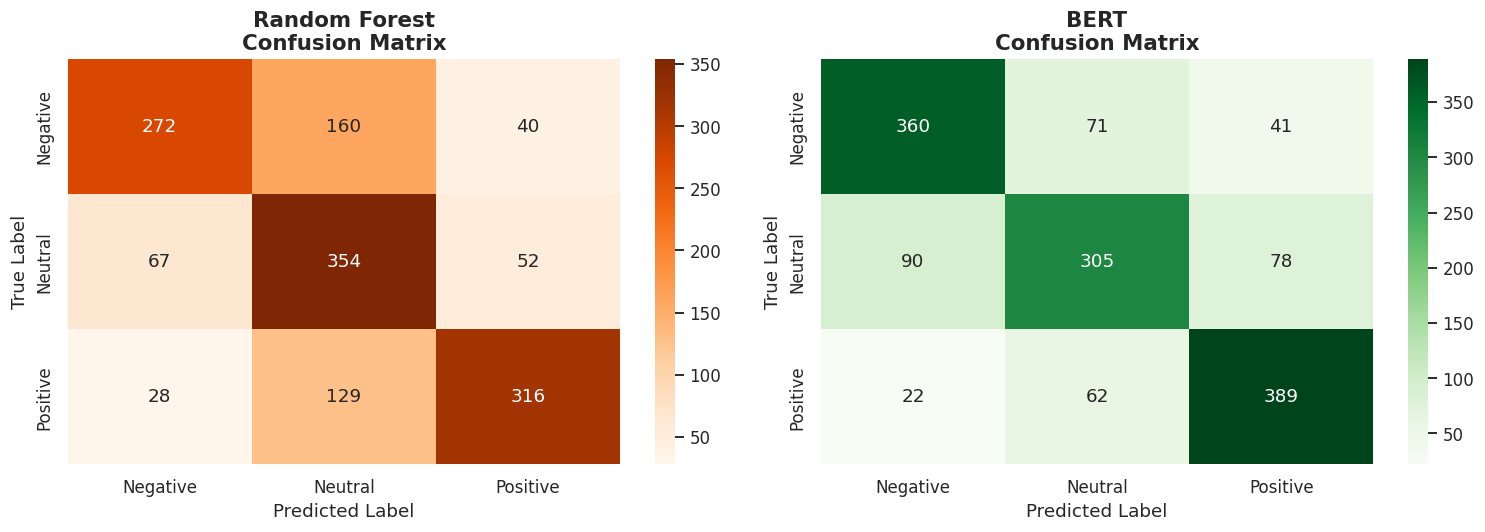


Performance Metrics Comparison (2 Models):
------------------------------------------------------------
        Model  Accuracy  F1-Score  Precision   Recall
Random Forest  0.664316  0.666735   0.688696 0.664316
         BERT  0.743300  0.741777   0.741587 0.743300


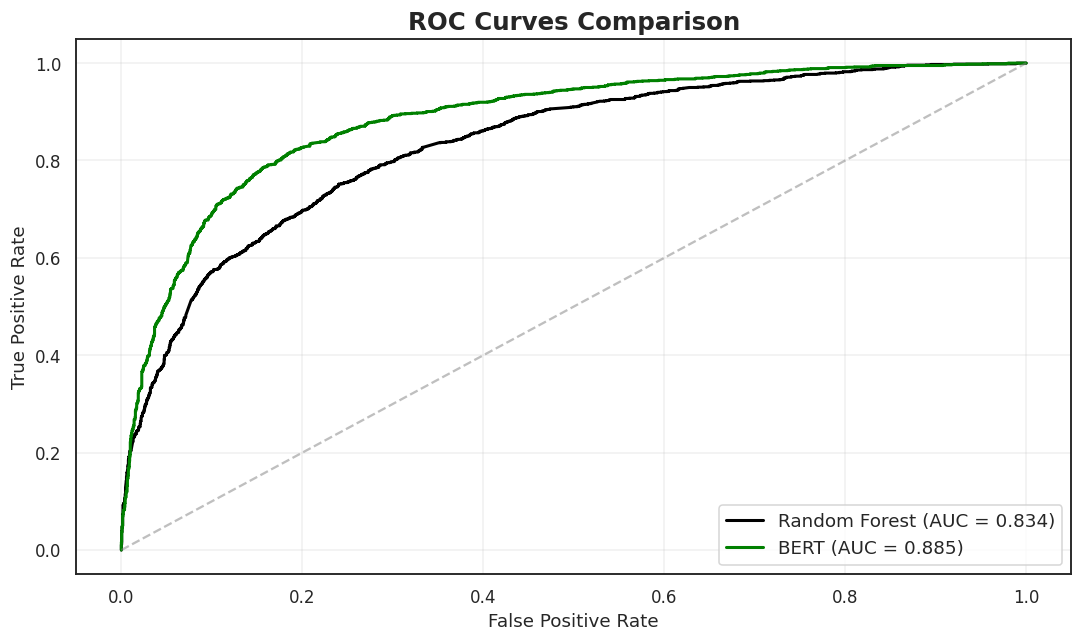

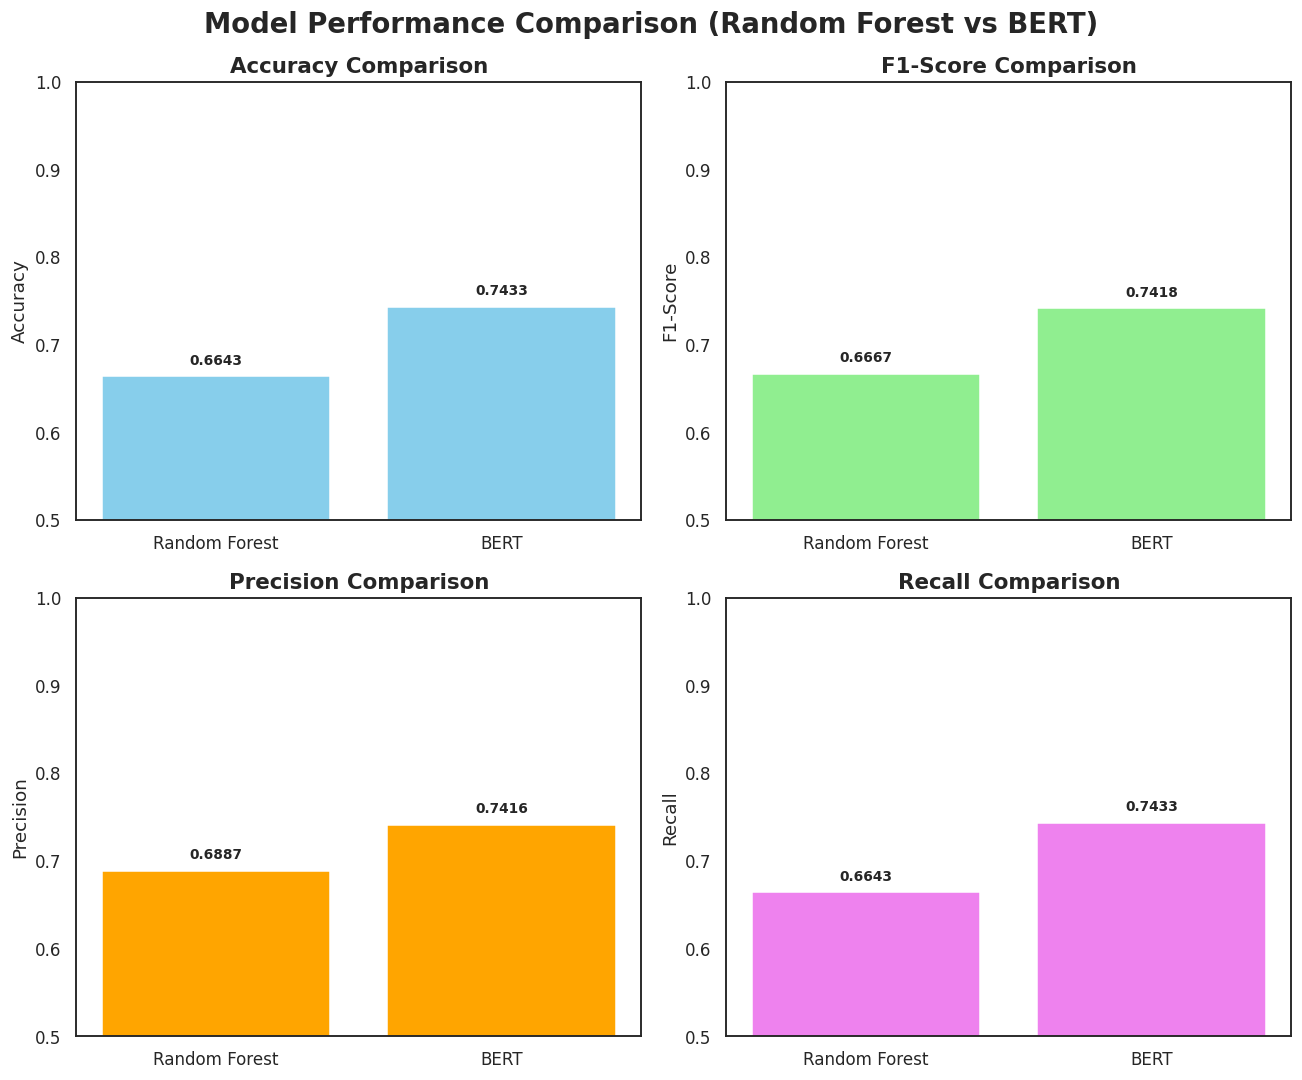

In [ ]:
# First, get BERT predictions and probabilities
bert_predictions_output = trainer.predict(test_dataset)
y_pred_bert = np.argmax(bert_predictions_output.predictions, axis=1)

# The outputs are logits → apply softmax to get probabilities
y_prob_bert = torch.softmax(
    torch.tensor(bert_predictions_output.predictions), dim=1
).numpy()

# Calculate accuracy for BOTH models (Random Forest + BERT)
rf_accuracy = accuracy_score(test_df['sentiment_label'], y_pred_rf)
bert_accuracy = accuracy_score(test_df['sentiment_label'], y_pred_bert)

# ======================================================
# VISUALIZATION: Confusion Matrices Comparison (2 models)
# ======================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

class_labels = ['Negative', 'Neutral', 'Positive']

# Random Forest Confusion Matrix
cm_rf = confusion_matrix(test_df['sentiment_label'], y_pred_rf)
sns.heatmap(
    cm_rf,
    annot=True,
    fmt='d',
    cmap='Oranges',
    xticklabels=class_labels,
    yticklabels=class_labels,
    ax=axes[0]
)
axes[0].set_title('Random Forest\nConfusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)

# BERT Confusion Matrix
cm_bert = confusion_matrix(test_df['sentiment_label'], y_pred_bert)
sns.heatmap(
    cm_bert,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=class_labels,
    yticklabels=class_labels,
    ax=axes[1]
)
axes[1].set_title('BERT\nConfusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)

plt.tight_layout()
plt.show()

# ======================================================
# VISUALIZATION: Model Performance Comparison
# ======================================================

# Classification report for BERT
bert_report = classification_report(
    test_df['sentiment_label'],
    y_pred_bert,
    target_names=class_labels,
    output_dict=True
)

bert_f1 = bert_report['weighted avg']['f1-score']
bert_precision = bert_report['weighted avg']['precision']
bert_recall = bert_report['weighted avg']['recall']

# Random Forest metrics
rf_f1 = f1_score(test_df['sentiment_label'], y_pred_rf, average='weighted')
rf_precision = precision_score(test_df['sentiment_label'], y_pred_rf, average='weighted')
rf_recall = recall_score(test_df['sentiment_label'], y_pred_rf, average='weighted')

comparison_data = {
    'Model': ['Random Forest', 'BERT'],
    'Accuracy': [rf_accuracy, bert_accuracy],
    'F1-Score': [rf_f1, bert_f1],
    'Precision': [rf_precision, bert_precision],
    'Recall': [rf_recall, bert_recall]
}

comparison_df = pd.DataFrame(comparison_data)

print("\nPerformance Metrics Comparison (2 Models):")
print("-" * 60)
print(comparison_df.to_string(index=False))


# VISUALIZATION 4: ROC Curves Comparison
plt.figure(figsize=(10, 6))

# ROC Curve for Random Forest
# Use 'sentiment_label' for true labels and 'y_prob_rf' for probabilities
fpr_rf, tpr_rf, _ = roc_curve(label_binarize(test_df['sentiment_label'], classes=[0, 1, 2]).ravel(), y_prob_rf.ravel())
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, color='black', lw=2,
         label=f'Random Forest (AUC = {roc_auc_rf:.3f})')

# ROC Curve for BERT
# Use 'sentiment_label' for true labels and 'y_prob_bert' for probabilities
fpr_bert, tpr_bert, _ = roc_curve(label_binarize(test_df['sentiment_label'], classes=[0, 1, 2]).ravel(), y_prob_bert.ravel())
roc_auc_bert = auc(fpr_bert, tpr_bert)
plt.plot(fpr_bert, tpr_bert, color='green', lw=2,
         label=f'BERT (AUC = {roc_auc_bert:.3f})')

# Diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', alpha=0.5)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# ======================================================
# BAR CHART VISUALIZATION (Same style)
# ======================================================
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
colors = ['skyblue', 'lightgreen', 'orange', 'violet']

for idx, metric in enumerate(metrics):
    bars = axes[idx].bar(
        comparison_df['Model'],
        comparison_df[metric],
        color=colors[idx]
    )
    axes[idx].set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    axes[idx].set_ylabel(metric, fontsize=12)
    axes[idx].set_ylim([0.5, 1.0])

    for bar, val in zip(bars, comparison_df[metric]):
        axes[idx].text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.01,
            f'{val:.4f}',
            ha='center',
            va='bottom',
            fontsize=9,
            fontweight='bold'
        )

plt.suptitle(
    'Model Performance Comparison (Random Forest vs BERT)',
    fontsize=18,
    fontweight='bold'
)
plt.tight_layout()
plt.show()


TESTING WITH CUSTOM EXAMPLES - ALL MODELS

----------------------------------------------------------------------
INDIVIDUAL PREDICTIONS
----------------------------------------------------------------------

Example 1:
Text: "This product is absolutely amazing! I love it so much."
--------------------------------------------------
Random Forest:        Positive   (60.50% confidence)
BERT:                 Positive   (99.34% confidence)

Example 2:
Text: "Worst purchase ever, complete waste of money."
--------------------------------------------------
Random Forest:        Negative   (52.31% confidence)
BERT:                 Negative   (99.33% confidence)

Example 3:
Text: "It's okay, not great but not terrible either."
--------------------------------------------------
Random Forest:        Positive   (52.22% confidence)
BERT:                 Positive   (81.77% confidence)

Example 4:
Text: "Excellent quality and fast delivery. Highly recommend!"
--------------------------------------

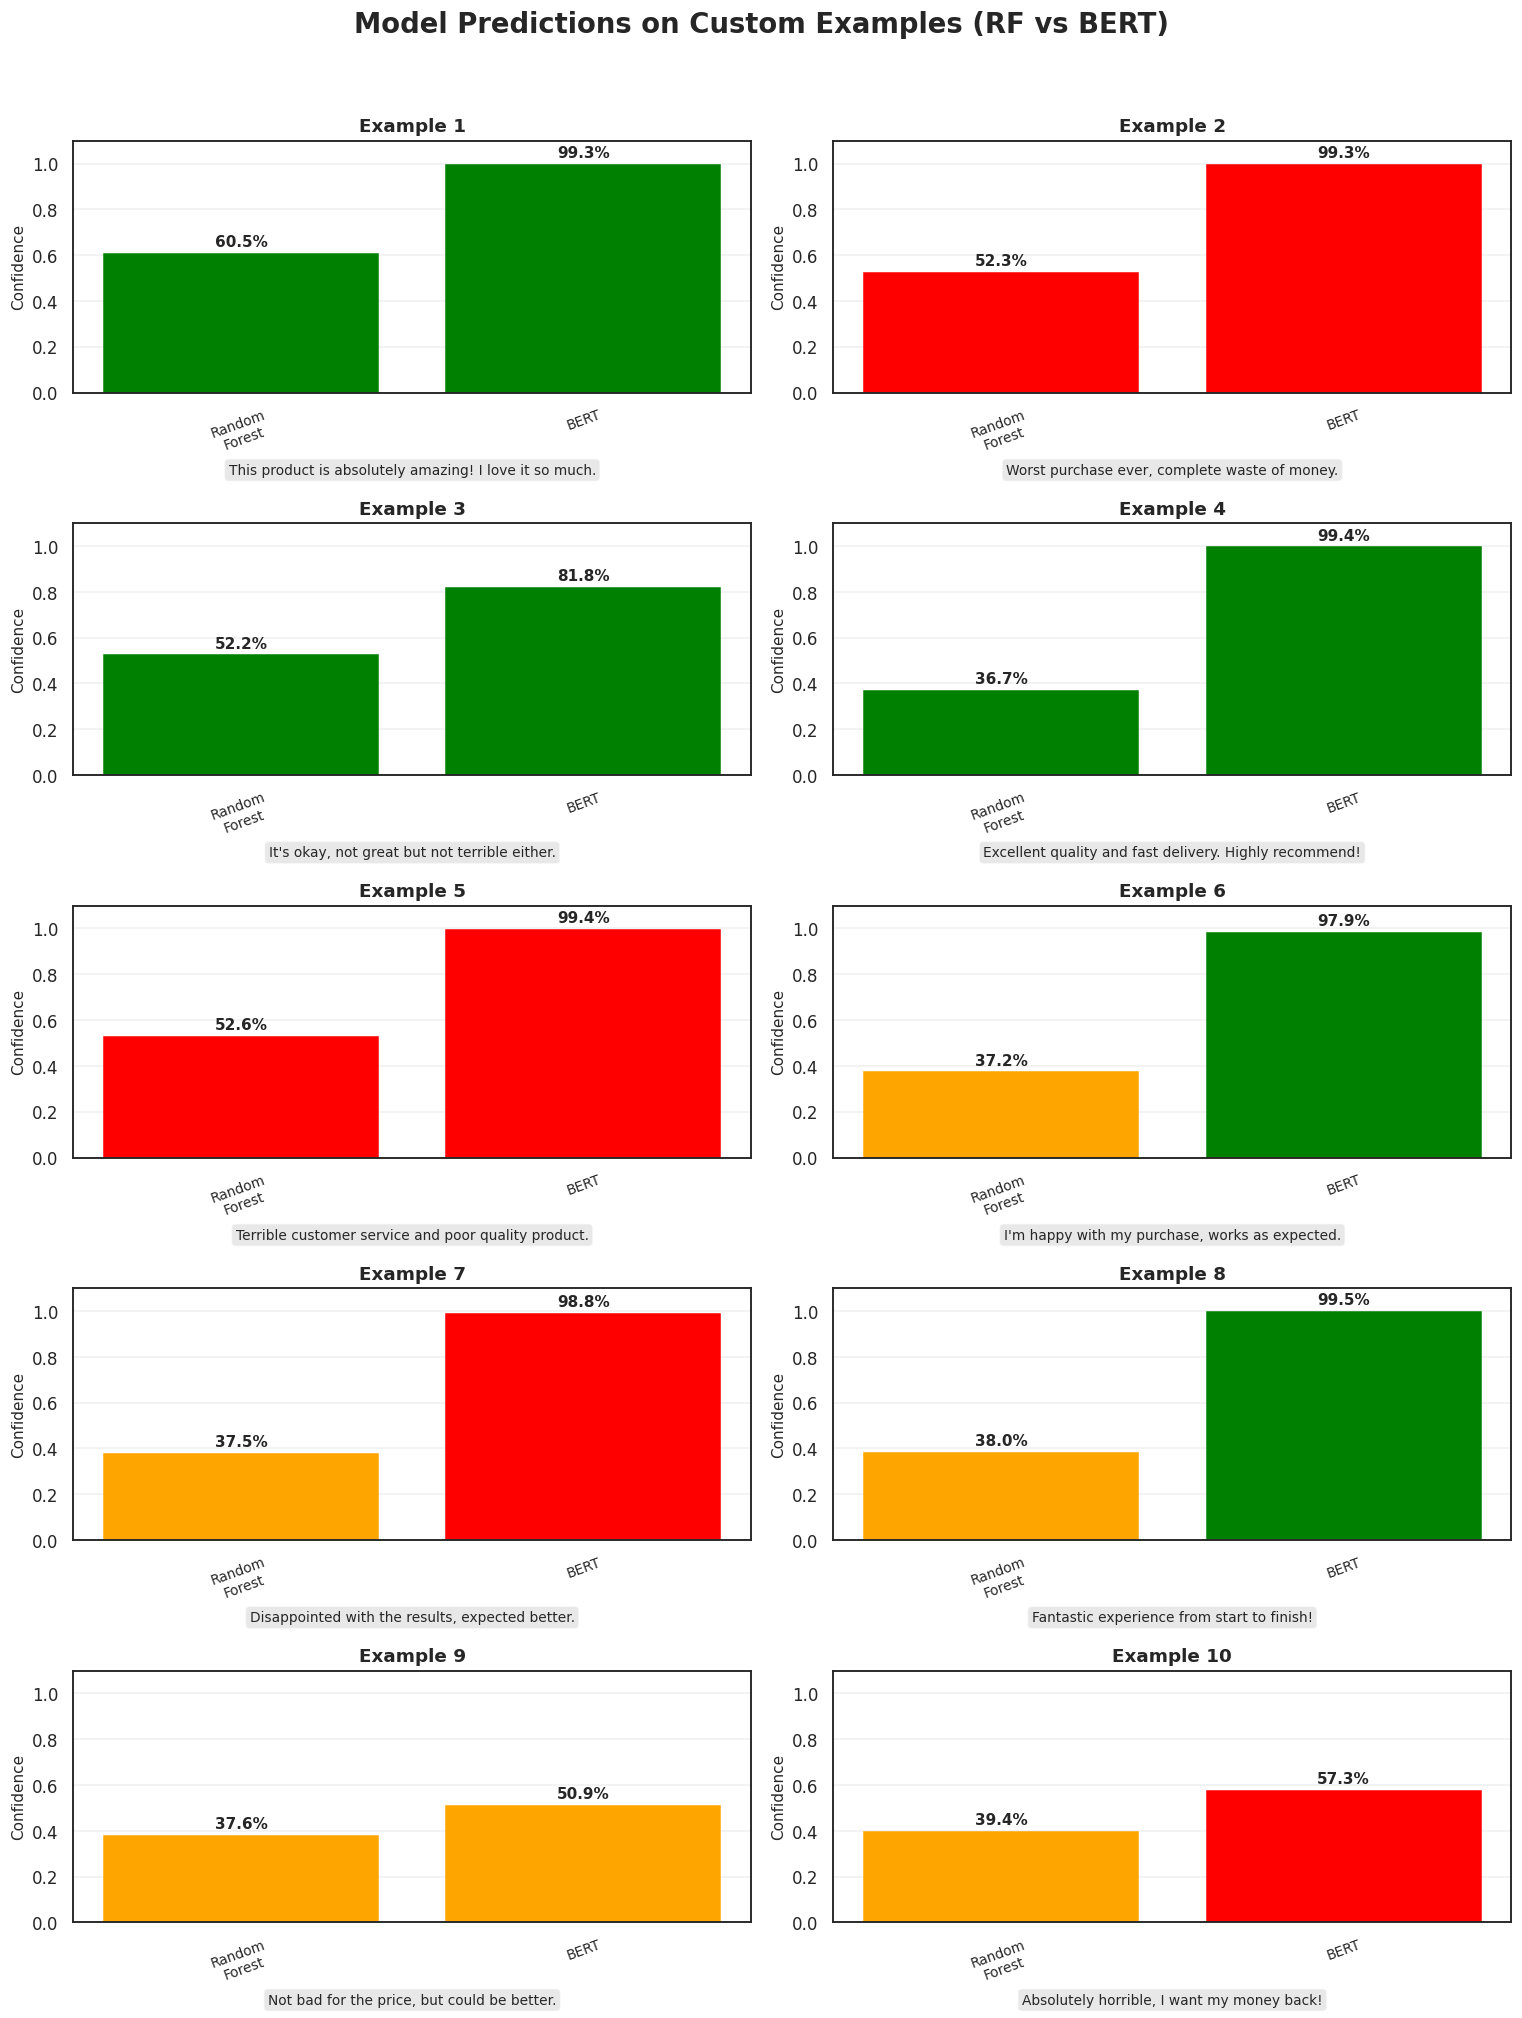

In [ ]:
# ==============================================
# TESTING WITH CUSTOM EXAMPLES - ALL MODELS
# ==============================================

print("\n" + "="*70)
print("TESTING WITH CUSTOM EXAMPLES - ALL MODELS")
print("="*70)

# Define custom test examples
custom_examples = [
    "This product is absolutely amazing! I love it so much.",
    "Worst purchase ever, complete waste of money.",
    "It's okay, not great but not terrible either.",
    "Excellent quality and fast delivery. Highly recommend!",
    "Terrible customer service and poor quality product.",
    "I'm happy with my purchase, works as expected.",
    "Disappointed with the results, expected better.",
    "Fantastic experience from start to finish!",
    "Not bad for the price, but could be better.",
    "Absolutely horrible, I want my money back!"
]

# ------------------------------
# Traditional model prediction
# ------------------------------
def predict_with_traditional_model(text, model, vectorizer):
    """Predict sentiment using traditional ML models"""
    text_vectorized = vectorizer.transform([text])
    prediction = model.predict(text_vectorized)[0]
    probability = model.predict_proba(text_vectorized)[0]

    if prediction == 0:
        sentiment = "Negative"
    elif prediction == 1:
        sentiment = "Neutral"
    else:
        sentiment = "Positive"

    confidence = probability[prediction]
    return sentiment, confidence, prediction

# ------------------------------
# BERT prediction (replaces DistilBERT)
# ------------------------------
def predict_with_bert(text):
    """Predict sentiment using BERT"""
    try:
        # Tokenize input
        inputs = tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=128
        )

        # Move to device
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Predict
        model.eval()
        with torch.no_grad():
            outputs = model(**inputs)

        # Probabilities + prediction
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
        prediction = torch.argmax(probabilities, dim=-1).item()

        if prediction == 0:
            sentiment = "Negative"
        elif prediction == 1:
            sentiment = "Neutral"
        else:
            sentiment = "Positive"

        confidence = probabilities[0][prediction].item()
        return sentiment, confidence, prediction

    except Exception as e:
        print(f"Error in BERT prediction: {e}")
        return "Error", 0.5, -1

# ------------------------------
# Test each example on all models
# ------------------------------
results = []

print("\n" + "-"*70)
print("INDIVIDUAL PREDICTIONS")
print("-"*70)

for i, text in enumerate(custom_examples, 1):
    print(f"\nExample {i}:")
    print(f"Text: \"{text}\"")
    print("-" * 50)

    # Random Forest
    rf_sentiment, rf_conf, rf_pred = predict_with_traditional_model(text, rf, tfidf_rf)
    print(f"Random Forest:        {rf_sentiment:10} ({rf_conf:.2%} confidence)")

    # BERT
    bert_sentiment, bert_conf, bert_pred = predict_with_bert(text)
    print(f"BERT:                 {bert_sentiment:10} ({bert_conf:.2%} confidence)")

    # Store results
    results.append({
        'text': text,
        'random_forest': (rf_sentiment, rf_conf, rf_pred),
        'bert': (bert_sentiment, bert_conf, bert_pred)
    })

# ==============================================
# VISUALIZATION: PREDICTIONS COMPARISON (2 models)
# ==============================================

print("\n" + "="*70)
print("VISUALIZATION: PREDICTIONS COMPARISON (2 MODELS)")
print("="*70)

fig, axes = plt.subplots(5, 2, figsize=(14, 18))
axes = axes.flatten()

model_names = ["Random\nForest", "BERT"]
model_keys = ["random_forest", "bert"]
base_colors = ["orange", "purple"]

for idx, example in enumerate(results[:10]):
    ax = axes[idx]

    sentiments = []
    confidences = []

    for key in model_keys:
        sentiment, confidence, _ = example[key]
        sentiments.append(sentiment)
        confidences.append(confidence)

    bars = ax.bar(model_names, confidences, color=base_colors)

    # Color bars based on sentiment
    for bar, sentiment in zip(bars, sentiments):
        if sentiment == "Positive":
            bar.set_color("green")
        elif sentiment == "Negative":
            bar.set_color("red")
        elif sentiment == "Neutral":
            bar.set_color("orange")
        else:
            bar.set_color("gray")

    ax.set_ylim([0, 1.1])
    ax.set_ylabel("Confidence", fontsize=10)
    ax.set_title(f"Example {idx+1}", fontsize=12, fontweight="bold")
    ax.tick_params(axis="x", rotation=20, labelsize=9)
    ax.grid(True, alpha=0.3, axis="y")

    # Add value labels
    for bar, conf in zip(bars, confidences):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2., height + 0.02,
            f"{conf:.1%}",
            ha="center", va="bottom",
            fontsize=10, fontweight="bold"
        )

    # Truncate text for display
    display_text = example["text"]
    if len(display_text) > 60:
        display_text = display_text[:57] + "..."

    ax.text(
        0.5, -0.28, display_text,
        ha="center", va="top",
        transform=ax.transAxes,
        fontsize=9, wrap=True,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.5)
    )

plt.suptitle("Model Predictions on Custom Examples (RF vs BERT)",
             fontsize=18, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()
